1         5
2         5
3         5
4         5
5         3
         ..
198852    5
198853    5
198854    3
198855    3
198856    3
Name: car_value_code, Length: 198856, dtype: int8
Remaining missing values after imputation:
cust_id              0
shopping_points      0
record_type          0
day                  0
time                 0
state                0
location             0
group_size           0
homeowner            0
car_age              0
car_value            0
risk_factor          0
age_oldest           0
age_youngest         0
married_couple       0
c_previous           0
duration_previous    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
cost                 0
car_value_code       0
dtype: int64


                time  duration_previous  car_value_code     state_code
count  198178.000000      198178.000000   198178.000000  198178.000000
mean      784.872811

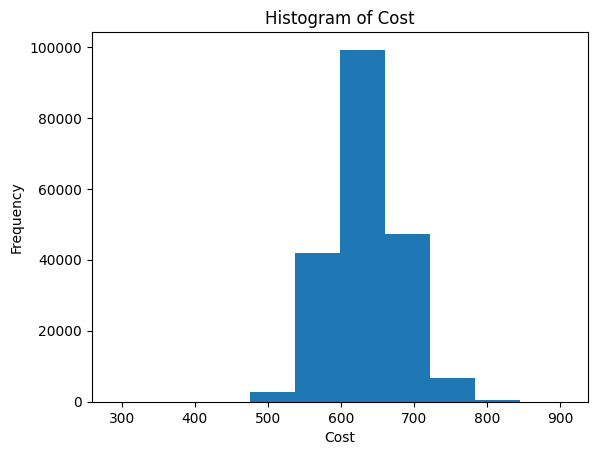

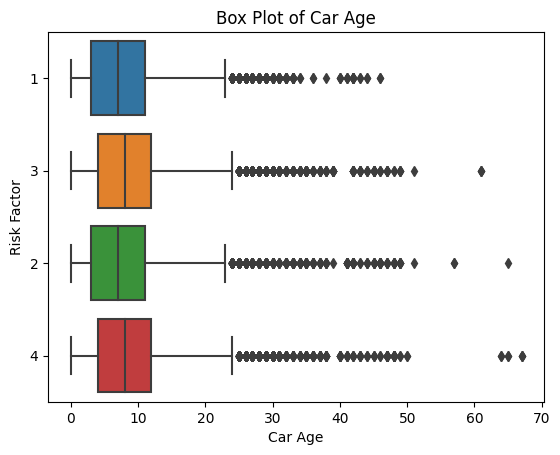

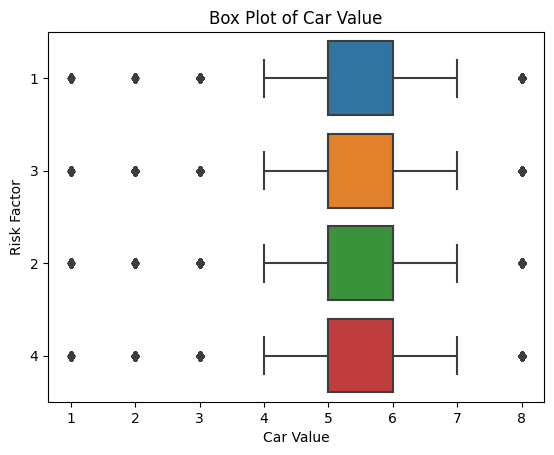

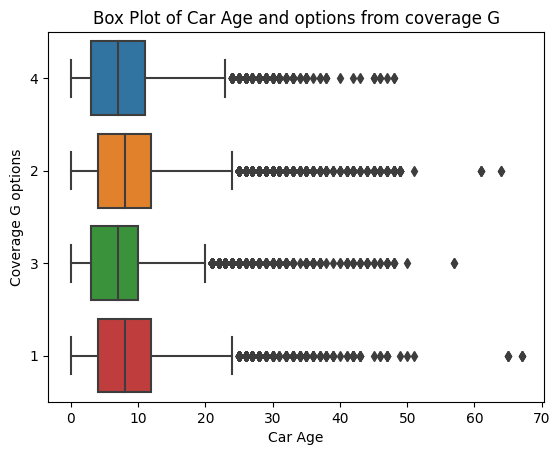

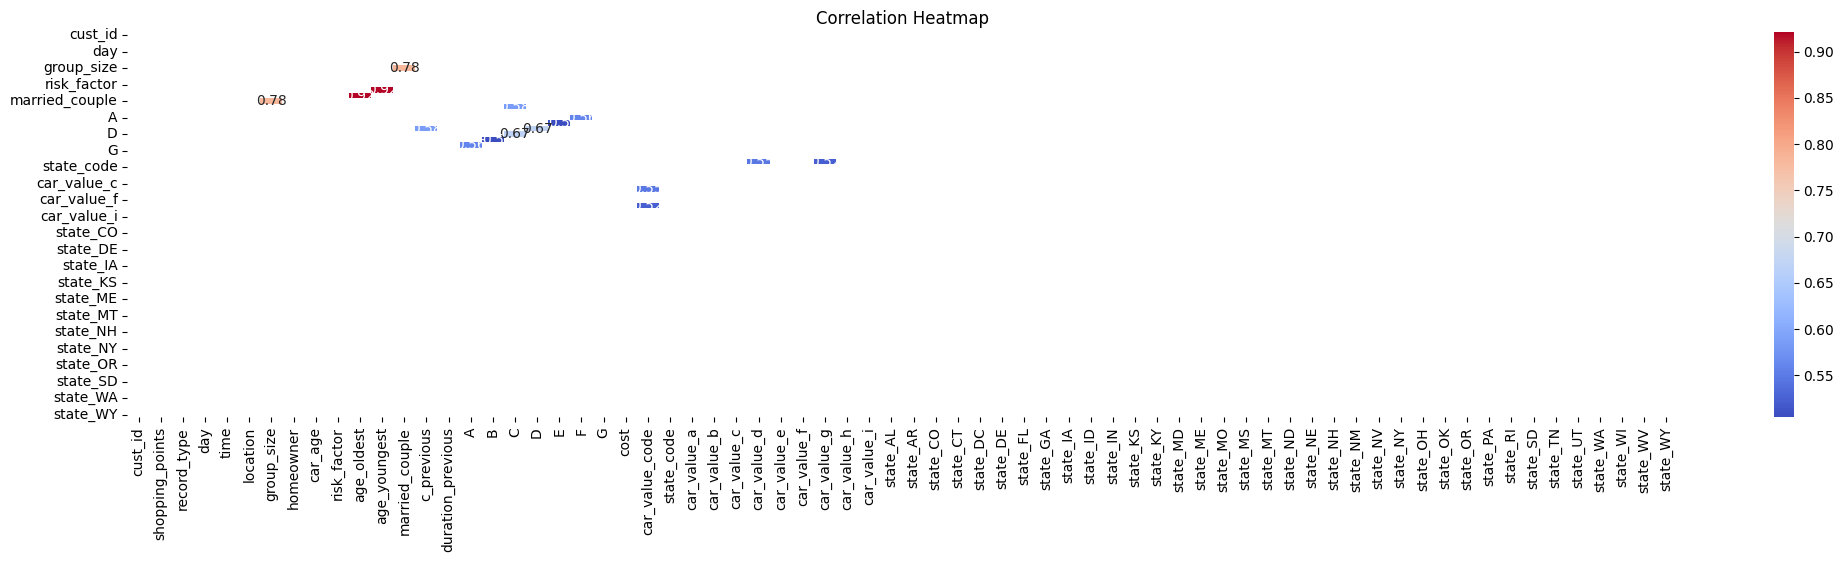

/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           1       0.67      0.69      0.68     14672
           2       0.65      0.65      0.65     13472
           3       0.68      0.67      0.67     17411
           4       0.67      0.66      0.67     13899

    accuracy                           0.67     59454
   macro avg       0.67      0.67      0.67     59454
weighted avg       0.67      0.67      0.67     59454

         feature  importance
21          cost    0.091892
4           time    0.082195
0        cust_id    0.071897
5       location    0.071018
10  age_youngest    0.063771
..           ...         ...
68      state_WY    0.000295
25   car_value_b    0.000279
62      state_SD    0.000164
24   car_value_a    0.000148
2    record_type    0.000000

[70 rows x 2 columns]
[0.05244952 0.09533554]


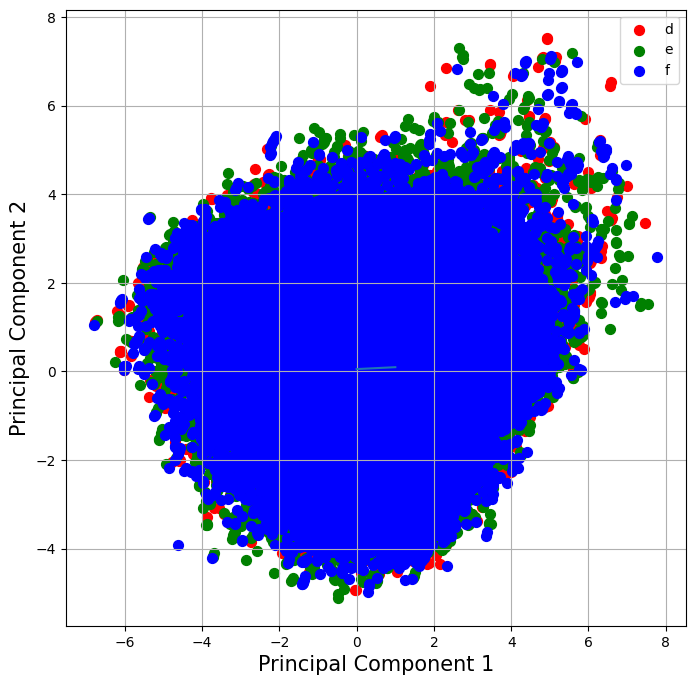

In [17]:
import pandas as pd
import numpy as np
import math

##After training, we are now onto testing.

df1 = pd.read_csv("test_v2.csv", header=None, low_memory=False)
df1.columns = ['cust_id', 'shopping_points', 'record_type', 'day', 'time', 'state', 'location', 'group_size',
               'homeowner', 'car_age', 'car_value',
               'risk_factor', 'age_oldest', 'age_youngest', 'married_couple', 'c_previous', 'duration_previous', 'A',
               'B', 'C', 'D', 'E', 'F', 'G',
               'cost']
df1.drop(index=df1.index[0], axis=0, inplace=True)
dataSet1 = df1.copy()
# This will be the main data set to work from. Follow this legend for certain column types
# record_type: 0= Shopping point, 1 = purchase point
# day: 0=Monday, 1=Tuesday, 2=Wednesday, 3=Thursday, 4=Friday, 5=Saturday, 6=Sunday
# time: HH:MM 24 hr time
# homeowner: 0=no, 1=yes
# car value: Measured in letters. Assuming that A is highest quality
# risk factor: Measured from 1-4 (Least to most)
# married_couple: 0=No, 1=yes
# c_previous: what value of option c has the customer already have? 0=nothing, 1, 2, 3, 4
# duration_previous: Measured in years
# For all coverages: 0 will be no coverage option
# A: 0, 1, 2
# B: 0, 1
# C: 1, 2, 3, 4
# D: 1, 2, 3
# E: 0, 1
# F: 0, 1, 2, 3
# G: 1,2,3,4


# Loop through all columns and print the column name and the number of missing values
# for column in df1.columns:
#     missing_values = df1[column].isnull().sum()
#     print(f"Number of missing values in {column}: {missing_values}")


from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

# Impute missing values for 'car_value' using mode
car_value_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df1['car_value'] = car_value_imputer.fit_transform(df1['car_value'].values.reshape(-1, 1))[:,0]

# Convert 'car_value' to numerical codes
df1['car_value_code'] = df1['car_value'].astype('category').cat.codes
print(df1['car_value_code'])
# Impute missing values for 'risk_factor' using K-nearest neighbors
# Select related features to base the KNN imputation on
related_features = df1[['car_age', 'car_value_code', 'cost', 'risk_factor']].copy()

# Split the data into available and missing risk_factor values
available_risk_factors = related_features[related_features['risk_factor'].notnull()]
missing_risk_factors = related_features[related_features['risk_factor'].isnull()]

# Train a KNeighborsClassifier on available data and predict missing values
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(available_risk_factors.drop('risk_factor', axis=1), available_risk_factors['risk_factor'])
predicted_risk_factors = knn.predict(missing_risk_factors.drop('risk_factor', axis=1))

# Replace missing risk_factor values with the predicted values
df1.loc[df1['risk_factor'].isnull(), 'risk_factor'] = predicted_risk_factors

# Impute missing values for 'c_previous' using mode
c_previous_imputer = SimpleImputer(strategy='most_frequent')
df1['c_previous'] = c_previous_imputer.fit_transform(df1['c_previous'].values.reshape(-1, 1))[:,0]

# Impute missing values for 'duration_previous' using median
duration_previous_imputer = SimpleImputer(strategy='median')
df1['duration_previous'] = duration_previous_imputer.fit_transform(df1['duration_previous'].values.reshape(-1, 1))

df1 = df1.dropna()

# Check for any remaining missing values
print("Remaining missing values after imputation:")
print(df1.isnull().sum())
print("\n")


def convert_time_to_minutes(time_str):
    hours, minutes = time_str.split(':')
    return int(hours) * 60 + int(minutes)


df1['time'] = df1['time'].apply(convert_time_to_minutes)
df1['state_code'] = df1['state'].astype('category').cat.codes
df1['car_value_code'] = df1['car_value'].astype('category').cat.codes
df2 = df1.copy()
df2 = pd.get_dummies(df2, columns=['car_value'])
df2 = pd.get_dummies(df2, columns=['state'])
# Your DataFrame: df1
#Using DataFrame2 for matrix


# Calculate the descriptive statistics for the dataset
desc_stats = df1.describe()
print(desc_stats)
print("\n")

import matplotlib.pyplot as plt
import seaborn as sns

# Use this histogram to show frequent sets of data.
# Cost is the main one to find usefulness from, but if any large variations of data need to be shown,
# use this code, changing bin size and tested column
plt.hist(df1['cost'].astype(int), bins=10)
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Histogram of Cost')
plt.show()

# Box plots to be used to compare two columns and their spread. Non tested example: High car ages has more consistent
# high risk factors than young car ages

# Convert the 'car_age' column to a numeric data type
df_box = df1.copy()
df_box['car_age'] = pd.to_numeric(df_box['car_age'], errors='coerce')
sns.boxplot(x=df_box['car_age'], y=df_box['risk_factor'])
plt.xlabel('Car Age')
plt.ylabel('Risk Factor')
plt.title('Box Plot of Car Age')
plt.show()

df_box['car_value'] = df_box['car_value'].replace('a', '1')
df_box['car_value'] = df_box['car_value'].replace('b', '2')
df_box['car_value'] = df_box['car_value'].replace('c', '3')
df_box['car_value'] = df_box['car_value'].replace('d', '4')
df_box['car_value'] = df_box['car_value'].replace('e', '5')
df_box['car_value'] = df_box['car_value'].replace('f', '6')
df_box['car_value'] = df_box['car_value'].replace('g', '7')
df_box['car_value'] = df_box['car_value'].replace('h', '8')
df_box['car_value'] = pd.to_numeric(df_box['car_value'], errors='coerce')
sns.boxplot(x=df_box['car_value'], y=df_box['risk_factor'])
plt.xlabel('Car Value')
plt.ylabel('Risk Factor')
plt.title('Box Plot of Car Value')
plt.show()

#Use the following for coverages, replacing the Y axis with the coverage being tested
df_box['car_age'] = pd.to_numeric(df_box['car_age'], errors='coerce')
sns.boxplot(x=df_box['car_age'], y=df_box['G'])
plt.xlabel('Car Age')
plt.ylabel('Coverage G options')
plt.title('Box Plot of Car Age and options from coverage G')
plt.show()


# Compute the correlation matrix
corr_matrix = df2.corr().abs()

# Filtering low correlation results
threshold = 0.5
filtered_corr_matrix = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)]

# Visualize the correlation matrix using a heatmap
# NOTE: To read might need to zoom in or open as image in Jupyter Notebook
plt.figure(figsize=(25,5))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the relevant features for clustering
features = df2[['car_age', 'cost']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

# Add the cluster labels to the original DataFrame
df2['cluster'] = kmeans.labels_

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Select the features and target variable
X = df2.drop('risk_factor', axis=1)
y = df2['risk_factor']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Calculate feature importances
importances = rf_clf.feature_importances_

# Sort features by importance and display the results
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

from sklearn.decomposition import PCA

# Select the relevant features for PCA
features = df2.drop('risk_factor', axis=1)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA with two components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
finalDf=pd.concat([principal_df,df1[['car_value']]],axis=1)

# Visualize the principal components in a scatter plot
# For some reason the explained_variance_ratio isn't returning anything, if someone can fix this this will be good
# TODO: Fix variance explanation
pca.fit_transform(scaled_features)
variance = pca.explained_variance_ratio_.cumsum()
print(variance)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1',fontsize = 15)  
ax.set_ylabel('Principal Component 2',fontsize = 15)  
targets=['d', 'e', 'f'] 
colors=['r','g','b']  
for target,color in zip(targets,colors):    
    indicesToKeep = finalDf['car_value'] == target  
    ax.scatter(finalDf.loc[indicesToKeep,'Principal Component 1'],
                finalDf.loc[indicesToKeep,'Principal Component 2'],
             c=color,
             s=50)
ax.legend(targets)
ax.grid()

plt.plot(variance)
plt.show()
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules



In [84]:
# Create a list of transactions based on various combinations of data points.
#Ones to be tested:
#car_value with A, B, C, D, E, F, G individually [car_value will be letters, the coverage will be numbers]
#Risk_factor with A, B, C, D, E, F, G individually [risk_factor will be proccessed into words]
#group_size with A, B, C, D, E, F, G individually [group_size proccessed with description of the size]
#homeowner with A, B, C, D, E, F, G individually [Homeowner will be proccessed with a description]
#day with A, B, C, D, E, F, G individually [Day will be proccessed with the day name]
#married_couple with A, B, C, D, E, F, G individually [married_couple will be processed with a description]

#REMEMBER: When analyzing results, look at lift (>1 positive association, <1 negative association, Exactly 1 no association)
#Lift further away from 1 are the more associated results. Take into consideration confidence as well.

df_copy = df1.copy()
df_copy['duration_previous'] = df_copy['duration_previous'].astype(str)
df_copy['car_age'] = df_copy['car_age'].astype(str)
df_copy['time'] = df_copy['time'].astype(str)
df_copy['risk_factor'] = df_copy['risk_factor'].replace('1', 'Low')
df_copy['risk_factor'] = df_copy['risk_factor'].replace('2', 'Medium')
df_copy['risk_factor'] = df_copy['risk_factor'].replace('3', 'High')
df_copy['risk_factor'] = df_copy['risk_factor'].replace('4', 'Very High')
df_copy2 = df_copy.copy()

df_copy2.loc[df_copy['group_size'].astype(int)<3, 'group_size']='Small'
df_copy2.loc[df_copy['group_size'].astype(int)==1, 'group_size']='Individual'
df_copy2.loc[df_copy['group_size'].astype(int)==3, 'group_size']='Medium'
df_copy2.loc[df_copy['group_size'].astype(int)>3, 'group_size']='Large'
df_copy['group_size'] = df_copy2['group_size']

df_copy['homeowner'] = df_copy['homeowner'].replace('0', 'Not A Home owner')
df_copy['homeowner'] = df_copy['homeowner'].replace('1', 'Home owner')

df_copy['day'] = df_copy['day'].replace('0', 'Monday')
df_copy['day'] = df_copy['day'].replace('1', 'Tuesday')
df_copy['day'] = df_copy['day'].replace('2', 'Wednesday')
df_copy['day'] = df_copy['day'].replace('3', 'Thursday')
df_copy['day'] = df_copy['day'].replace('4', 'Friday')
df_copy['day'] = df_copy['day'].replace('5', 'Saturday')
df_copy['day'] = df_copy['day'].replace('6', 'Sunday')

df_copy['married_couple'] = df_copy['married_couple'].replace('0', 'Not Married')
df_copy['married_couple'] = df_copy['married_couple'].replace('1', 'Married')

transactions = df_copy[['day', 'G']].values.tolist()

# Encode the transactions into a binary format
encoder = TransactionEncoder()
encoded_transactions = encoder.fit_transform(transactions)
transaction_df = pd.DataFrame(encoded_transactions, columns=encoder.columns_)

# Apply the Apriori algorithm to find frequent itemsets
min_support = 0.1 # Adjust this value based on your dataset
frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
# Generate association rules
min_confidence = 0.3# Adjust this value based on your desired level of confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
print(rules)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []
